Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Connor McDonald"
StudentNumber = "u16040725"

---

# MIT 804 2021: Homework 3, part 4 [25 points]
## Genetic Algorithm and the JSE

**You will learn how to:**
- Solve the portfolio allocation problem with a genetic algorithm

Data is from [https://github.com/dsfsi/dsfsi-datasets](https://github.com/dsfsi/dsfsi-datasets)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import urllib.request

filename = "top40_jse_2021_performance.csv"
if not os.path.isfile(filename):
    url = "https://raw.githubusercontent.com/dsfsi/dsfsi-datasets/master/data/stocks/top40_jse_2021_performance.csv"
    urllib.request.urlretrieve(url, filename)

In [4]:
df = pd.read_csv(filename,index_col='Date')
df.head()

,PRX,ANH,NPN,BTI,GLN,CFR,BHP,AGL,AMS,FSR,...,PPH,OMU,BVT,CLS,REM,MCG,MRP,ARI,WHL,EXX
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,159202.0,103934.0,303695.0,55100.0,4964.0,13462.0,40605.0,51374.0,151216.0,4950.0,...,1326.0,1164.0,15526.0,25368.0,9510.0,13301.0,16689.0,27553.0,3907.0,14894.0
2021-01-05,165757.0,105282.0,311667.0,56900.0,5105.0,13747.0,41750.0,52356.0,145650.0,4811.0,...,1302.0,1134.0,15081.0,25628.0,9516.0,13335.0,16458.0,27610.0,3837.0,14546.0
2021-01-06,165753.0,108600.0,310100.0,57834.0,5612.0,13615.0,44140.0,55970.0,146903.0,4878.0,...,1300.0,1152.0,15414.0,25543.0,9600.0,13299.0,16156.0,27285.0,3801.0,14741.0
2021-01-07,160297.0,110500.0,301375.0,58404.0,5777.0,14368.0,45777.0,58548.0,151000.0,5038.0,...,1292.0,1200.0,15452.0,25396.0,9820.0,13666.0,16027.0,28067.0,3819.0,15499.0
2021-01-08,160091.0,107658.0,307027.0,58130.0,5692.0,14348.0,45615.0,58217.0,149548.0,5231.0,...,1347.0,1206.0,15736.0,26241.0,10043.0,13987.0,16661.0,28850.0,4016.0,15761.0


## A plot of the top stock

Text(0, 0.5, 'Stock Price, ZAR')

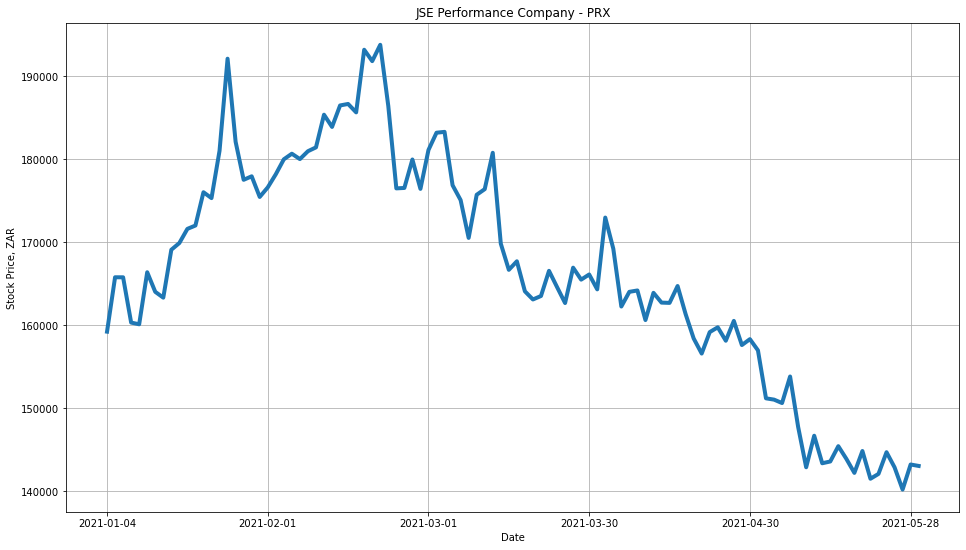

In [5]:
df.PRX.plot(figsize = (16,9),linewidth=4)
plt.grid()
plt.title("JSE Performance Company - PRX")
plt.ylabel("Stock Price, ZAR")

## 1 Stock Portfolio Allocation

A popular question that is asked to ML researchers is why we dont work on predicting stock market performance so that we can pick stocks to invest in. There are many reasons for this, one being that past performance does not say much about future perfomance. In this notebook we will take a look at this problem through trying to put together a stock portfolio that would have done well through the latter shock of COVID19 in Q1 2021. 

### 1.1 Weighting our portfolio [2 points]

For this problem, we will start with a weighting of the stocks. Use the `np.random.rand` function to create a random weighting for `num_dim` stocks. The weighting should always add up to 1.0 so you must adjust for this. 

In [6]:
def initialise_weighting(num_dim):
    nums = np.random.rand(1, num_dim)[0]
    weighting =[]
    for i in nums:
        weighting.append(i/sum(nums))
    return weighting

In [7]:
num_dim = 10
weighting = initialise_weighting(num_dim)
assert len(weighting) == 10
assert np.sum(weighting) < 1.00000001
assert np.sum(weighting) > 0.99999999

### 1.2 Adjusting weight to Budget [2 points]

We now need to calculate the amount of allocated money to each stock and then calculate how many stocks would have been purchased per specific day.

**Note**: We are assuming we are buying an instrument such as an ETF, so we can buy fractions of stocks. 

In [8]:
def adjust_stocks_by_weighting(budget, weighting, stock_prices):
    budget_allocation = []
    stock_weighting = []
    for i in weighting:
        budget_allocation.append(i*budget)

    for i in range(len(budget_allocation)):
        stock_weighting.append(budget_allocation[i]/stock_prices[i])
    stock_weighting = np.array(stock_weighting)
    
    return stock_weighting

In [9]:
budget = 5.0
weighting = np.array([0.2, 0.2 ,0.2 ,0.2, 0.2])
stock_prices = np.array([1, 2, 2, 4, 5])
adjust_stocks_by_weighting(budget, weighting, stock_prices)

array([1.  , 0.5 , 0.5 , 0.25, 0.2 ])

In [10]:
budget = 5.0
weighting = np.array([0.2, 0.2 ,0.2 ,0.2, 0.2])
stock_prices = np.array([1, 2, 2, 4, 5])
stock_weighting = adjust_stocks_by_weighting(budget, weighting, stock_prices)
assert len(stock_weighting) == 5
assert stock_weighting[0] == 1.0
assert np.isclose(stock_weighting[2],0.5,atol=0.0001)

### Rules for our stock picking problem

1. Every stock has its own cost that is charged per stock per month
2. Every run of this algorithm will have a different budget given to you
3. Non linearities are introduced by having different tiered costs added in [e.g. having more than 10 stocks in your portfolio has extra costs added per month, as well as having more then 20 etc.]
4. We are going to assume costs are calculated daily and adjusted by the number of days in the year. Then summed. 

### 1.3 Calculating values and costs

* Provide a simple calculation to give the complete value of the portfolio given the stock_weighting and individual stock prices. This should be implemented in `portfolio_value`
* Calculate the cost of the porfolio given values for a specifi. Assume a 
    * *2%* per share per annum cost for up to 5 shares, 
    * *1%* per share per annum for 10 Shares (we have more than 5 unique shares, but less than 11), 
    * *0.75%* per share per annum for up to 20 shares,
    * and a 50% cost per share per annum for more than 20 shares in the portfolio (having more then 20). 
Implement this in `portfolio_costs`    

In [11]:
def portfolio_value(stock_weighting, stock_prices): 
    stock_prices = np.nan_to_num(stock_prices)
    value = stock_weighting*stock_prices
    return np.sum(value)

def portfolio_costs(stock_weighting, period_stock_values):
    num_unique_stocks = np.sum(stock_weighting>0) ## How many unique shares do you have.
    daily_cost = []
    for day_stock_value in period_stock_values:
        day_stock_value  = np.nan_to_num(day_stock_value)
        
        if num_unique_stocks <= 5:
            daily_cost.append(0.02*portfolio_value(stock_weighting, day_stock_value))
    
        elif num_unique_stocks <= 10:
            daily_cost.append(0.01*portfolio_value(stock_weighting, day_stock_value))

        elif num_unique_stocks <= 20:
            daily_cost.append(0.0075*portfolio_value(stock_weighting, day_stock_value))
            
        else:
            daily_cost.append(0.5*portfolio_value(stock_weighting, day_stock_value)) 

    full_cost = np.sum(daily_cost)/365.0
    return full_cost

In [12]:
stock_weighting = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
stock_price = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) 
value = portfolio_value(stock_weighting, stock_price)
assert np.isclose(value,10.0,atol=0.001)

stock_weighting = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
period_stock_values = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]) # 2 Days
full_cost = portfolio_costs(stock_weighting,period_stock_values)
assert np.isclose(full_cost,0.02/365,atol=0.001)

stock_weighting = np.array([0.25, 3.0, 1])
period_stock_values = np.array([[100, 50, 75],[101, 44, 69],[99, 55, 68]]) # 3 Days
full_cost = portfolio_costs(stock_weighting,period_stock_values)
assert np.isclose(full_cost,0.04022,atol=0.0201)

## 2 Genetic Algorithm


### 2.1 Chromosome and populaton

You would have done this in the prior assignment so we are going to write out the result.

In [13]:
def initialise_chromosome(chromosome_size):
    chromosome = initialise_weighting(chromosome_size)
    return chromosome
def initialise_population(population_size, chromosome_size):
    population = []
    for i in range(population_size):
        population.append(initialise_chromosome(chromosome_size))
    return population

In [14]:
type(initialise_population(5, 2)[0])

list

In [15]:
num_stocks = 40
chromosome = initialise_chromosome(num_stocks)
print(chromosome)
population_size =10
population = initialise_population(population_size, num_stocks)

[0.03345701478470624, 0.02794899254450704, 0.00973790664279994, 0.0290976166686535, 0.016723207273194162, 0.027840863392012256, 0.0032210153908224922, 0.03588892230646781, 0.02317526943265728, 0.036394253716257895, 0.03045486329968288, 0.03825664926186866, 0.02185871909938565, 0.030724262109823992, 0.03627756369967378, 0.016690958740368765, 0.001483920337166928, 0.01710480962938713, 0.005253256124762337, 0.03461999685982851, 0.039837493614196244, 0.03209570588537759, 0.03728281252288656, 0.018529163139006162, 0.034465288515041256, 0.01715295297285866, 0.03753269316915062, 0.027950293141317112, 0.03189130967027715, 0.024219540364208435, 0.0073386225209583315, 0.04152198029906181, 0.028517536517174032, 0.0405748217943482, 0.007546527044798716, 0.029844195174706527, 0.016494517775421488, 0.0019559103817492138, 0.026707562933492877, 0.02233101124994162]


### 2.2 Calculate fitness

Fitness the is potfolio value on the last day at hand, and the cost is the total cost since buying the stock. 

In [16]:
def calculate_fitness(population, budget, stock_prices_timeline):
    fitness_list = []
    for chromosome in population:
        # Weighting at the beginning of the period
        stock_weighting = adjust_stocks_by_weighting(budget ,chromosome, stock_prices_timeline.iloc[0].values) 
        
        value = portfolio_value(stock_weighting, stock_prices_timeline.iloc[-1].values)
        cost = portfolio_costs(stock_weighting, stock_prices_timeline.iloc[1:].values)
        # Value at the end of the period
        fitness_list.append(value - cost)
    return fitness_list

In [17]:
budget = 1000000
# Stock prices from the last day of January 2020
stock_prices_timeline = df.loc["2020-01-31":]
calculate_fitness(population, budget, stock_prices_timeline)[:5]

[1005901.7677919407,
 996190.1169765734,
 996826.7362747369,
 1028988.7682444832,
 996285.7738876189]

### 2.3 Selection. Pairing, Crossover and Mutation

This is were the magic happens. You will be giving the selection and pairing code. You must implement the child generation and mutation code.

In [18]:
def selection(population, fitness_list):
    ## Select the top half of the best of the population
    population = np.array(population)
    sorted_indices = np.argsort(fitness_list)
    selection_point = int(1+ len(fitness_list)/2)
    
    # Randomply permute this top half of the poulation
    indices = np.random.choice(sorted_indices[:selection_point], len(population))
    best_population = population[indices]
    return best_population

def pairing(selected_population):
    ## pair up parents that will be used to reproduce
    count = 0
    pairs = []
    while count < len(selected_population)-1:
        index = count
        pairs.append([selected_population[index],selected_population[index+1]])
        count +=2
    return pairs

### 2.3.1 Create child, reproduce [3 points]

You must implement the child generation. This will be different from HW3 Part 3. We will use a weighted average cross over. You can come up with other ways to do this and test them yourself later.

An example is shown below

**Step 1:**

Parent_A - [0.2, 0.2, 0.2, 0.2, 0.2]

Parent_B - [0.4, 0.1, 0.1, 0.2, 0.2]

**Step 2:** Randomly Weighted Average Between parents to create a child

Draw weight for A randomly from 0 to 1 (use np.random.uniform()) 

e.g. **a_weight** = 0.5

> **b_weight** = 1.0 - **a_weight**. 

In ths example **b_weight** =0.5


Child - **a_weight** x Parent_A + **b_weight** x Parent_B

**Finally:**

Child - [0.3, 0.15, 0.15, 0.2, 0.2]

In [19]:
def create_child(a,b):
    child = []
    a_weight = np.random.uniform(0,1)
    b_weight = 1 - a_weight
    for i in range(len(a)):
        c = a_weight*a[i] + b_weight*b[i]
        child.append(c)
    return child

def cross_over(pairs):    
    final_population = []
    for a,b in pairs:
        child = create_child(a,b)
        final_population.append(child)
        child = create_child(b,a)
        final_population.append(child)
    return final_population


In [20]:
pairs = [[np.array([0.1,0.5,0.4]),np.array([0.2,0.3,0.5])]]
child = create_child(pairs[0][0],pairs[0][1])
assert len(child) == 3
assert np.sum(child) == 1.0
assert np.max(child) <= 1.0
assert np.min(child) >= 0.0

### 2.3.2 Mutation [3 points]

You will get as input a population of chrosmosomes. For each chromosome, you can can add noise to the whole chromosome. Control the amount of noise using a scale factor. 


*Input:* Population of chromosomes
*Output:* Population of chromosomes that had added noise. And then normalised to add back to one. 

In [21]:
def mutation(population, scale_factor = 1):
    final_population = []
    for i in population:
        noisy_chromosome = []
        norm = []
        for j in i:
            n = j + np.random.normal(0, scale_factor)
            if n < 0: 
                n = 0.000000000001
                noisy_chromosome.append(n)
            else:
                noisy_chromosome.append(n)

        for i in noisy_chromosome:
            norm.append(i/sum(noisy_chromosome))

        final_population.append(norm)

    return final_population

In [22]:
population = [[0,1]]
output = mutation(population)
assert len(output) == 1
assert len(output[0]) == 2
assert np.isclose(np.sum(output[0]),1.0)
assert output[0][0] != population[0][0]
population = [[0,0.4,0.6]]
output = mutation(population)
assert len(output) == 1
assert len(output[0]) == 3
assert np.isclose(np.sum(output[0]),1.0)
assert output[0][0]  > 0

### 2.3.3 Putting it all together

In [23]:
num_stocks = 40
population_size = 100
num_iterations = 100
budget = 1000000
# Stock prices from the last day of January 2020
stock_prices_timeline = df.loc["2020-01-31":]

In [24]:
# Genetic Algorithm
population= initialise_population(population_size=population_size, chromosome_size=num_stocks)
best_performance = -1000000
best_chromosome = []
best_performance_history = []
performance_history = []
for i in range(num_iterations):
    # Calculate the fitness of all chromosomes in the population
    performances = calculate_fitness(population, budget, stock_prices_timeline)
    # If the new population has the best distance, save it.
    if np.max(performances) > best_performance:
        best_performance = np.max(performances)
        best = np.argmax(performances)
        best_chromosome = population[best]
        best_performance_history.append(best_performance)
    performance_history.append(np.mean(performances))
    # 1. Do selection
    selected_population = selection(population, performances)
    # 2. Pair the good chromosomes 
    pairs = pairing(selected_population)
    # 3. Reproduce with cross over
    crossed_over = cross_over(pairs)
    # 4. Add some randomness with mutation
    population = mutation(crossed_over)

performances = calculate_fitness(population, budget, stock_prices_timeline)
# If the new population has the best distance, save it.
if np.max(performances) > best_performance:
    best_performance = np.max(performances)
    best = np.argmax(performances)
    best_chromosome = population[best]
    best_performance_history.append(best_performance)
performance_history.append(np.mean(performances))
print("Distances: " ,performances[:5])
print("Population: ",population[:2])
print("Best chromosome: ",best_chromosome)
print("Best (shortest) distance: ",best_performance)

Distances:  [1054990.8039300418, 965360.9977641997, 1018942.3039933143, 1037987.0667393568, 1026996.2118109141]
Population:  [[6.77245848618532e-14, 6.77245848618532e-14, 0.016805269053024242, 0.022893653066649707, 6.77245848618532e-14, 6.77245848618532e-14, 0.01062336772241024, 6.77245848618532e-14, 0.024817453427549027, 6.77245848618532e-14, 0.10682571239288995, 0.07666701227157445, 0.03412618205682917, 6.77245848618532e-14, 0.08033467440598331, 0.09170135496762477, 0.03690981163620749, 6.77245848618532e-14, 6.77245848618532e-14, 0.005873434238882088, 6.77245848618532e-14, 0.0008326231963514386, 6.77245848618532e-14, 6.77245848618532e-14, 0.028128138512027615, 6.77245848618532e-14, 0.05808593555164221, 6.77245848618532e-14, 6.77245848618532e-14, 0.023570192849345497, 0.09903777285429455, 0.029032054479256927, 0.06532746931760287, 0.007177547390436645, 0.0767156836372312, 0.029860461440298337, 0.07465419553066885, 6.77245848618532e-14, 6.77245848618532e-14, 6.77245848618532e-14], [6.1

In [25]:
stock_weighting = adjust_stocks_by_weighting(budget ,best_chromosome, stock_prices_timeline.iloc[0].values)
stock_weighting_avg = adjust_stocks_by_weighting(budget ,np.ones(40)/40, stock_prices_timeline.iloc[0].values)

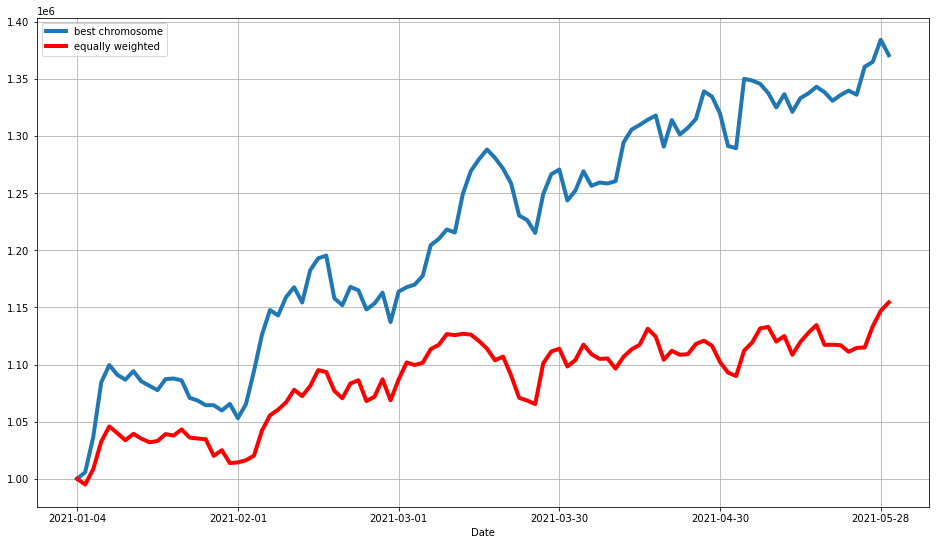

In [26]:
avg = stock_weighting*stock_prices_timeline
avg.sum(axis=1).plot(figsize=(16,9), label='best chromosome',linewidth=4)
equally = stock_weighting_avg*stock_prices_timeline
equally.sum(axis=1).plot(figsize=(16,9), color='r', label='equally weighted',linewidth=4)
plt.grid()
plt.legend()

Text(0.5, 0, 'Sample number')

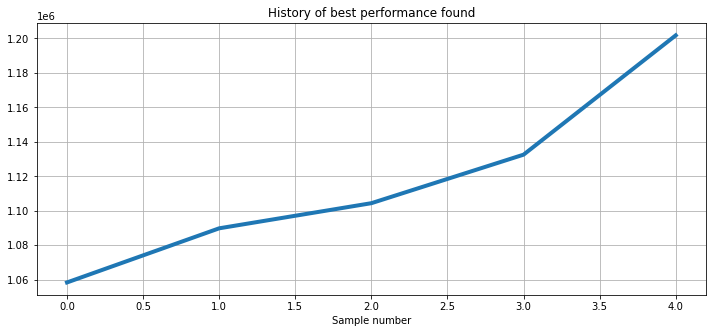

In [27]:
plt.figure(figsize= (12,5))
plt.plot(best_performance_history,linewidth=4)
plt.title("History of best performance found")
plt.grid()
plt.xlabel("Sample number")

Text(0.5, 0, 'Sample number')

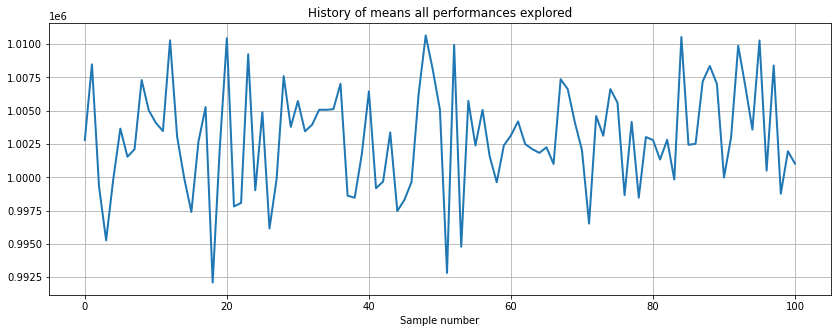

In [28]:
plt.figure(figsize= (14,5))
plt.plot(performance_history,linewidth=2)
plt.title("History of means all performances explored")
plt.grid()
plt.xlabel("Sample number")

### 2.4 Observations [10 points]
1. What do you observe with the behaviour of the Genetic Algorithm in this case? [2 points]
2. From HW 3 part 3, what are the most interesting changes for you [2points]
3. How would you improve the fitness function, how would you add the cost, how would you improve the mutattion [6 points]. Try this and report.

1. This algorithm consisted of a much more complicated chromosome structure than the travelling salesman chromosome, as we were no longer restricted to integers for our gene values. Another thing which was noticed was that the algorithm often performed poorly with the initial noise scale factor of 0.01. I suspect this is because our search space was restricted to a small range and causing our algorithm to get caught in a local max which was much lower than the global max.

2. This algorthim used an interesting appraoch to breeding the chromosomes and mutating them, using a weighted average of parents and a normal distribution for mutation seems like a more natural way to create the next generation, rather than just swapping exact values like we did in HW3. Obviously HW3 required a method like this since the gene values needed to be integers, but I believe that the method used in HW3 would not have been as effective in predicting stock combinations as the weighted average method.


3. To improve th fitness function I would possbily use price to earnings ratio or earnings per share ratio to encourage the algortihm to maximise profit and minimise cost simultaneously rather than just maximising profit as it is currently doing. To imporve the cost function I would calculate costs on a monthly basis as stated in the question and I would use the exact value, not the daily average. For the mutation function I would use a much higher scale factor (around 1.0) to expand the search region and prevent getting stuck on a local max, furthermore, if the addition of noise resulted in a negative stock weighting, I would allow the algorthim to set this equal to 0, so that it can try combinations with various numbers of unique stocks rather than being constrained to 40. Lastly, I would change the pairing process to be a roulette wheel where each chromosome is allocated a spot in proportion to its fitness, this would increase the chances of the best individuals getting paired together rather than pairing them all randomly.